# Import Required Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Instantiate a grid from a DEM raster
Some sample data is already included, but for extra data, see the [USGS hydrosheds project](https://hydrosheds.cr.usgs.gov/datadownload.php).

In [2]:
grid = Grid.from_raster('data/n30w100_con_grid/n30w100_con/n30w100_con', data_name='dem')

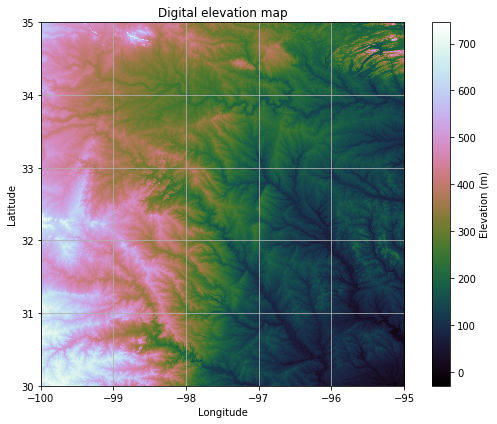

In [3]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('img/conditioned_dem.png', bbox_inches='tight')

## Resolve flats in DEM

In [4]:
grid.resolve_flats('dem', out_name='inflated_dem')

## Specify flow direction values

In [5]:
#         N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [6]:
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

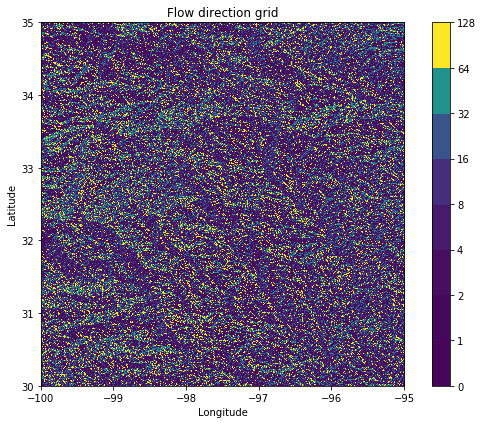

In [7]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid')
plt.grid(zorder=-1)
plt.tight_layout()
plt.savefig('img/flow_direction.png', bbox_inches='tight')

In [8]:
grid.read_raster('data/n30w100_dir_grid/n30w100_dir/n30w100_dir', data_name='dir')

In [9]:
grid.dir

Raster([[ 64,  64,  64, ...,   1,   2, 128],
        [ 32,  64,  64, ...,   1,   1, 128],
        [ 32,  32,  32, ...,   1, 128,  64],
        ...,
        [128,  64,  64, ...,  16,   8,   4],
        [128,  64,  64, ...,   4,  16,   4],
        [  8,  64,  64, ...,   8,   4,   4]], dtype=uint8)

In [10]:
grid.dir.size

36000000

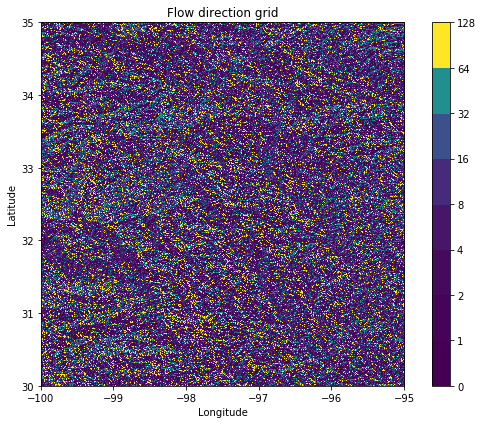

In [11]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid')
plt.grid(zorder=-1)
plt.tight_layout()

## Delineate the Catchment

In [12]:
# Specify pour point
# x, y = -97.294167, 32.73750
x, y = -97.36, 32.65

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

In [13]:
# Clip the bounding box to the catchment
grid.clip_to('catch')

In [14]:
# Get a view of the catchment
catch = grid.view('catch', nodata=np.nan)

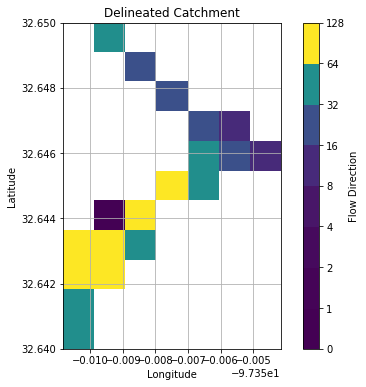

In [15]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
plt.colorbar(im, ax=ax, boundaries=boundaries, values=sorted(dirmap), label='Flow Direction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment')
plt.savefig('img/catchment.png', bbox_inches='tight')

## Get flow accumulation

In [16]:
grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')

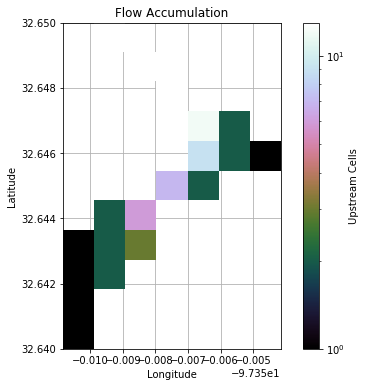

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('img/flow_accumulation.png', bbox_inches='tight')


## Calculate distances to upstream cells

In [18]:
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist',
                   xytype='label', nodata_out=np.nan)

ValueError: Pour point (-97.36, 32.65) is out of bounds for dataset with bbox (-97.36083333333345, 32.639999999999894, -97.35416666666679, 32.64999999999989).

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(grid.dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance')
plt.savefig('img/flow_distance.png', bbox_inches='tight')